In [1]:
import numpy as np 
import pandas as pd 
import pandas_profiling
import sklearn
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from scipy import sparse,spatial
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tqdm
import csv
import umap.umap_ 
import seaborn as sns 
sns.set(style='white', rc={'figure.figsize':(10,8)})

In [2]:
usa_2018_df = pd.read_csv('usa_2018_cars')

In [3]:
usa_2018_df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
usa_car_categorical_df = usa_2018_df[['model_id','model_make_display','model_engine_compression','model_make_id','model_name','model_trim']]
usa_car_numerical_df = usa_2018_df.drop(['model_make_display','model_engine_compression','model_make_id','model_name','model_trim'],axis=1)
usa_car_numerical_df.set_index('model_id',inplace=True)
usa_car_categorical_df.set_index('model_id',inplace=True)
usa_car_numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3230 entries, 71344 to 76481
Data columns (total 19 columns):
model_year                     3230 non-null int64
model_body                     3230 non-null object
model_engine_position          3230 non-null object
model_engine_cc                3230 non-null float64
model_engine_cyl               3230 non-null float64
model_engine_type              3230 non-null object
model_engine_valves_per_cyl    3230 non-null float64
model_engine_power_ps          3230 non-null float64
model_engine_torque_nm         3230 non-null float64
model_engine_fuel              3230 non-null object
model_drive                    3230 non-null object
model_transmission_type        3230 non-null object
model_doors                    3230 non-null float64
model_weight_kg                3230 non-null float64
model_lkm_hwy                  3230 non-null float64
model_lkm_mixed                3230 non-null float64
model_lkm_city                 3230 non-null flo

# For converting metric units into USA standards
for an approximate result, divide the speed value by 1.609
mm to in divide the length value by 25.4
kg to lbs for an approximate result, multiply the mass value by 2.205
l to gal for an approximate result, divide the volume value by 3.785

In [7]:
def lkm_to_mpg(lkm):
    return round((3.785411784*(lkm/1.609344)),1)

def mm_to_inches(mm):
    return round(mm/25.4,1)

def l_to_gal(l):
    return round(l/3.785,1)

def nm_to_ftlbs(nm):
    return round(nm*0.73756,1)


In [8]:
pandas_profiling.ProfileReport(usa_car_numerical_df)

In [5]:
#Taking Away the columns that are highly correlated
usa_car_numerical_df.drop(['model_lkm_hwy','model_lkm_city','model_engine_cc',
                           'model_fuel_cap_l','model_engine_power_ps',],axis=1,inplace=True) 

In [8]:
#Conversions
usa_car_numerical_df['average_mpg'] = usa_car_numerical_df['model_lkm_mixed']
# usa_car_numerical_df['model_horsepower'] = usa_car_numerical_df['model_engine_power_ps']
# usa_car_numerical_df['fuel_cap_galons'] = usa_car_numerical_df['model_fuel_cap_l']
usa_car_numerical_df['engine_ft_lbs_torque'] = usa_car_numerical_df['model_engine_torque_nm'].apply(nm_to_ftlbs)


In [9]:
#Dropping the old columns in metric values
usa_car_numerical_df.drop(['model_lkm_mixed','model_engine_torque_nm',],axis=1,inplace=True)

In [10]:
#Taking away the constant feautres in the dataset
usa_car_numerical_df.drop('model_engine_position',axis=1,inplace=True)
usa_car_numerical_df.drop('model_sold_in_us',axis=1,inplace=True)

In [13]:
pandas_profiling.ProfileReport(usa_car_numerical_df)

In [11]:
#Getting dummy variables for other features that are categorical
usa_car_numerical_df = pd.get_dummies(usa_car_numerical_df,columns=['model_body','model_drive',
                                                                    'model_engine_type','model_engine_fuel',
                                                                    'model_transmission_type'],drop_first=True)

Trying 3 different scaler fits 

In [12]:
ss = StandardScaler()
ss = ss.fit_transform(usa_car_numerical_df)

robsca = RobustScaler()
robsca = robsca.fit_transform(usa_car_numerical_df)

pow_trans = PowerTransformer()
pow_trans = pow_trans.fit_transform(usa_car_numerical_df)

Run a Shiloutte Score to see the best number of clusters 

100%|██████████| 98/98 [01:42<00:00,  1.70s/it]


Text(0, 0.5, 'Variation')

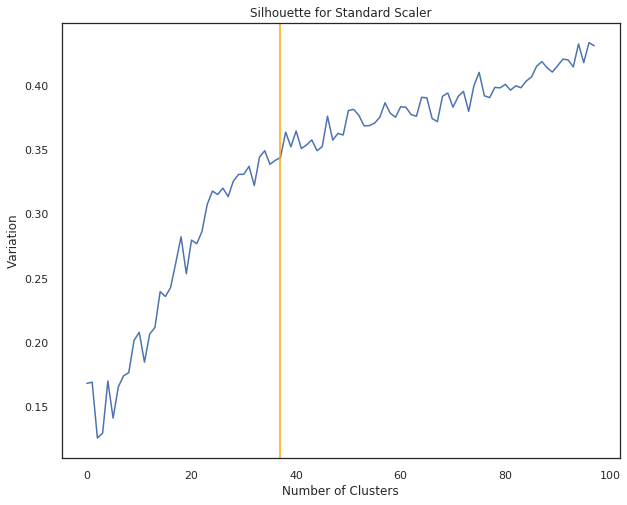

In [176]:
silhouette_scores = []
for n in tqdm.tqdm(range(2,100)):
    n_model = KMeans(n_clusters=n)
    n_model.fit(ss)
    silhouette_scores.append(silhouette_score(ss, n_model.labels_))
plt.plot(silhouette_scores)
plt.axvline(37, color='orange')
plt.title('Silhouette for Standard Scaler')
plt.xlabel('Number of Clusters')
plt.ylabel('Variation')

Run a Shiloutte Score with Robust Scaler to see the best number of clusters 

100%|██████████| 98/98 [02:10<00:00,  2.17s/it]


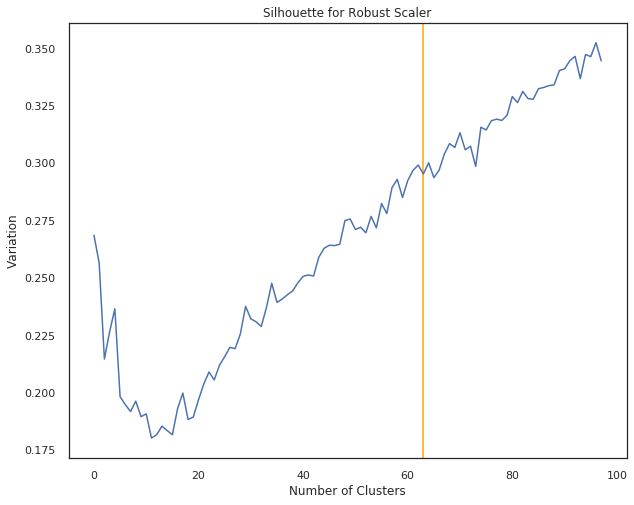

In [197]:
silhouette_scores = []
for n in tqdm.tqdm(range(2,100)):
    n_model = KMeans(n_clusters=n)
    n_model.fit(robsca)
    silhouette_scores.append(silhouette_score(robsca, n_model.labels_))
plt.axvline(63, color='orange')
plt.title('Silhouette for Robust Scaler')
plt.xlabel('Number of Clusters')
plt.ylabel('Variation')
plt.plot(silhouette_scores)

Run a Shiloutte Score with Power Transfromer to see the best number of clusters

100%|██████████| 98/98 [02:05<00:00,  1.98s/it]


Text(0, 0.5, 'Variation')

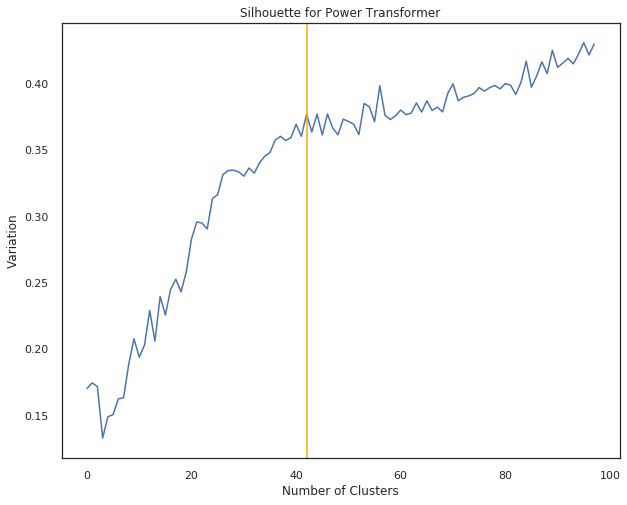

In [200]:
silhouette_scores = []
for n in tqdm.tqdm(range(2,100)):
    n_model = KMeans(n_clusters=n)
    n_model.fit(pow_trans)
    silhouette_scores.append(silhouette_score(pow_trans, n_model.labels_))
plt.plot(silhouette_scores)
plt.axvline(42, color='orange')
plt.title('Silhouette for Power Transformer')
plt.xlabel('Number of Clusters')
plt.ylabel('Variation')

First KMeans with the Standard Scaler 

In [13]:
kmeans = KMeans(n_clusters=37, init='k-means++', n_init=10, max_iter=300, 
                tol=0.0001, precompute_distances=True,verbose=3, random_state=42, copy_x=True,
                n_jobs=None, algorithm='auto').fit(ss)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 25135.84441851761
start iteration
done sorting
end inner loop
Iteration 1, inertia 23695.326141013673
start iteration
done sorting
end inner loop
Iteration 2, inertia 23385.67607862579
start iteration
done sorting
end inner loop
Iteration 3, inertia 23367.40494324118
start iteration
done sorting
end inner loop
Iteration 4, inertia 23367.40494324118
center shift 0.000000e+00 within tolerance 1.000000e-04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 25633.88106579634
start iteration
done sorting
end inner loop
Iteration 1, inertia 24264.682366129568
start iteration
done sorting
end inner loop
Iteration 2, inertia 24124.72211324421
start iteration
done sorting
end inner loop
Iteration 3, inertia 24043.79293620856
start iteration
done sorting
end inner loop
Iteration 4, inertia 23998.15139468548
start iteration
done sorting
end inner loop
Iteration 5, inertia

Now trying the model with the RobustScaler

In [198]:
model = KMeans(n_clusters=63,init='k-means++', max_iter=100, n_init=1,verbose=2)
model.fit(robsca)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3905.097828400779
start iteration
done sorting
end inner loop
Iteration 1, inertia 3704.854273800802
start iteration
done sorting
end inner loop
Iteration 2, inertia 3616.696816383145
start iteration
done sorting
end inner loop
Iteration 3, inertia 3583.9875157106176
start iteration
done sorting
end inner loop
Iteration 4, inertia 3565.8014107337817
start iteration
done sorting
end inner loop
Iteration 5, inertia 3544.1295247524176
start iteration
done sorting
end inner loop
Iteration 6, inertia 3538.1675502459866
start iteration
done sorting
end inner loop
Iteration 7, inertia 3536.576922616386
start iteration
done sorting
end inner loop
Iteration 8, inertia 3536.4057844022086
start iteration
done sorting
end inner loop
Iteration 9, inertia 3536.4057844022086
center shift 0.000000e+00 within tolerance 1.699573e-05


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=63, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=2)

Now on the Power Transformer 

In [199]:
model = KMeans(n_clusters=42,init='k-means++', max_iter=100, n_init=1,verbose=2)
model.fit(pow_trans)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 22794.445423437526
start iteration
done sorting
end inner loop
Iteration 1, inertia 22066.228559521558
start iteration
done sorting
end inner loop
Iteration 2, inertia 21841.303553018897
start iteration
done sorting
end inner loop
Iteration 3, inertia 21747.36022327415
start iteration
done sorting
end inner loop
Iteration 4, inertia 21685.416894136943
start iteration
done sorting
end inner loop
Iteration 5, inertia 21250.61358067017
start iteration
done sorting
end inner loop
Iteration 6, inertia 21214.325231246337
start iteration
done sorting
end inner loop
Iteration 7, inertia 21195.680632468393
start iteration
done sorting
end inner loop
Iteration 8, inertia 21170.75498366023
start iteration
done sorting
end inner loop
Iteration 9, inertia 21170.75498366023
center shift 0.000000e+00 within tolerance 1.000000e-04


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=42, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=2)

In [14]:
#Creating a dataframe with only the make and model 
no_model_trim = usa_car_categorical_df.drop('model_trim',axis=1)
just_model_id_name = no_model_trim.drop(['model_make_display','model_engine_compression'],axis=1)

In [15]:
#Finding which clusters are close to each other 
def get_model_id_name(cluster):
    for num in cluster:
        x_shape = np.argwhere(kmeans.labels_ == num).shape[0]
        args = np.argwhere(kmeans.labels_ == num).reshape(x_shape,)
        print(just_model_id_name.iloc[args])
        
get_model_id_name([33,6])

         model_make_id      model_name
model_id                              
73195        Chevrolet  Silverado 1500
73202        Chevrolet  Silverado 1500
73205        Chevrolet  Silverado 1500
73206        Chevrolet  Silverado 1500
73207        Chevrolet  Silverado 1500
73217        Chevrolet  Silverado 1500
73219        Chevrolet  Silverado 1500
73302           Toyota          Tundra
73304           Toyota          Tundra
73310           Toyota          Tundra
73311           Toyota          Tundra
73313           Toyota          Tundra
73315           Toyota          Tundra
73321           Toyota          Tundra
73322           Toyota          Tundra
73323           Toyota          Tundra
73324           Toyota          Tundra
73325           Toyota          Tundra
73327           Toyota          Tundra
73328           Toyota          Tundra
73329           Toyota          Tundra
73330           Toyota          Tundra
73331           Toyota          Tundra
73332           Toyota   

/home/colin/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 73 separate connected components using meta-embedding (experimental)
  n_components


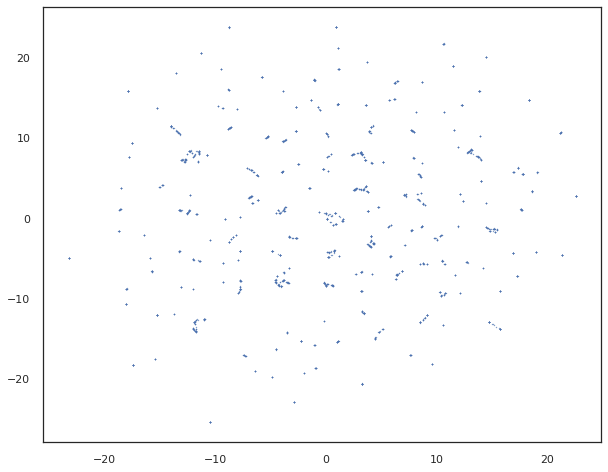

In [17]:
#Doing some UMAP locally
import umap.umap_ 
import seaborn as sns 
sns.set(style='white', rc={'figure.figsize':(10,8)})
standard_embedding = umap.umap_.UMAP(random_state=42).fit_transform(ss)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');

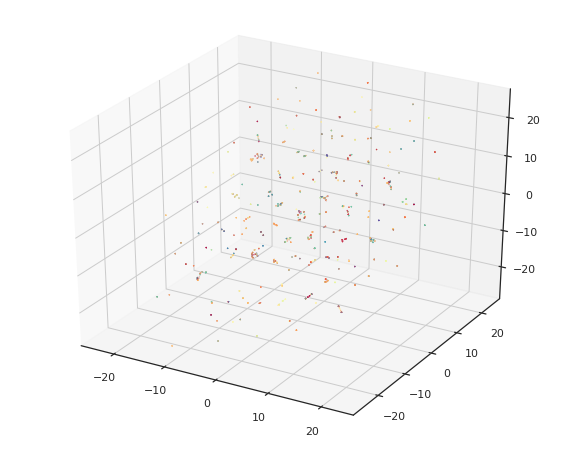

In [148]:
from mpl_toolkits.mplot3d import Axes3D
kmeans_labels = KMeans(n_clusters=37).fit_predict(usa_car_numerical_df)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(standard_embedding[:, 0], standard_embedding[:, 1],
            standard_embedding[:,1], c=kmeans_labels, s=0.1, cmap='Spectral');

DBSCAN - Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

In [19]:
from sklearn.cluster import DBSCAN
# class sklearn.cluster.DBSCAN(eps=0.5, min_samples=5, metric='cosine',
#                              metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)

In [20]:
dbscan_cluster = DBSCAN(eps=0.5, min_samples=10, metric='cosine',
                        metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)

In [201]:
dbscan_cluster.fit(ss)
dbscan_ss_df = dbscan_cluster.components_

In [202]:
dbscan_cluster.fit(robsca)
dbscan_robsca_df = dbscan_cluster.components_

In [203]:
dbscan_cluster.fit(pow_trans)
dbscan_powtrans_df = dbscan_cluster.components_

In [204]:
pd.DataFrame(dbscan_ss_df).to_csv('dbscan_ss_vectors.tsv',sep='\t', quoting=csv.QUOTE_NONE)
pd.DataFrame(dbscan_robsca_df).to_csv('dbscan_robsca_vectors.tsv',sep='\t', quoting=csv.QUOTE_NONE)
pd.DataFrame(dbscan_powtrans_df).to_csv('dbscan_powtrans_vectors.tsv',sep='\t', quoting=csv.QUOTE_NONE)

In [205]:
similarity_array_ss = cosine_similarity(dbscan_ss_df, Y=None, dense_output=True)
similarity_array_robsca = cosine_similarity(dbscan_robsca_df, Y=None, dense_output=True)
similarity_array_powtrans = cosine_similarity(dbscan_powtrans_df, Y=None, dense_output=True)

In [206]:
cosine_angles_ss = np.sort(np.absolute(similarity_array_ss),axis=1)[:,1:11]
cosine_angles_robsca = np.sort(np.absolute(similarity_array_robsca),axis=1)[:,1:11]
cosine_angles_powtrans = np.sort(np.absolute(similarity_array_powtrans),axis=1)[:,1:11]

In [207]:
np.sort(np.absolute(similarity_array_ss),axis=1)[:,:11]

array([[1.44996352e-04, 1.44996352e-04, 1.85216803e-04, ...,
        5.82960248e-04, 5.82960248e-04, 5.82960248e-04],
       [7.83920987e-05, 7.83920987e-05, 7.83920987e-05, ...,
        2.74522092e-04, 2.74522092e-04, 4.14012350e-04],
       [3.84454191e-04, 5.53187251e-04, 5.53187251e-04, ...,
        7.57823049e-04, 7.57823049e-04, 9.46622469e-04],
       ...,
       [1.90463546e-05, 8.41613821e-05, 1.04168686e-04, ...,
        1.65534342e-04, 1.65534342e-04, 1.65534342e-04],
       [3.29462144e-04, 3.95556588e-04, 3.95556588e-04, ...,
        7.06771162e-04, 8.12559444e-04, 8.78112330e-04],
       [1.05699094e-04, 1.05699094e-04, 1.05699094e-04, ...,
        2.98501179e-04, 3.17945483e-04, 3.17945483e-04]])

In [208]:
cosine_angles_robsca

array([[8.92134157e-05, 2.38768189e-04, 2.38768189e-04, ...,
        9.86804849e-04, 1.01791029e-03, 1.19656679e-03],
       [1.31188852e-03, 3.41221083e-03, 3.41503135e-03, ...,
        3.81929604e-03, 4.38894019e-03, 4.52238084e-03],
       [8.01075614e-05, 9.89812669e-04, 9.89812669e-04, ...,
        1.53599922e-03, 1.80493062e-03, 1.80493062e-03],
       ...,
       [2.97513159e-03, 3.18183782e-03, 3.18183782e-03, ...,
        8.64836876e-03, 9.37115081e-03, 9.37565544e-03],
       [3.02900653e-02, 3.02900653e-02, 3.05343447e-02, ...,
        3.21594868e-02, 3.21648452e-02, 3.22736485e-02],
       [1.19413211e-03, 1.20167890e-03, 4.46817259e-03, ...,
        1.10947903e-02, 1.10947903e-02, 1.10947903e-02]])

In [230]:
rev_cosine_array = np.flip(np.argsort(np.absolute(similarity_array_powtrans),axis=1))[:,1:8]

In [231]:
rev_cosine_array

array([[2619, 2618, 3216, ..., 1608, 1010, 1009],
       [2618, 2619, 3217, ..., 1607, 1009, 1010],
       [3214, 3213, 3212, ..., 2957, 1606, 1605],
       ...,
       [1611,   22,  500, ..., 2109, 1265,  561],
       [  31, 1610, 1640, ...,  622,  840,  299],
       [ 953, 1133, 1194, ..., 1191, 1196, 1609]])

In [29]:
usa_car_categorical_df.iloc[1610]

model_make_display                                  Nissan
model_engine_compression                              10.3
model_make_id                                       Nissan
model_name                                          Murano
model_trim                  SV 4dr SUV AWD (3.5L 6cyl CVT)
Name: 73889, dtype: object

In [ ]:
just_model_id_name.reset_index(inplace=True)
just_model_id_name.drop('model_id',axis=1,inplace=True)

In [232]:
def get_similar_cars(df,model,name):
    mask = df[(df['model_make_id']== model)& (df['model_name'] == name)] 
    mask_list = mask.index
    similar_cars = defaultdict()
    for index in mask_list:
        lookup_array = rev_cosine_array[(3217 - index)]
        for n_index in lookup_array:
            car = df.iloc[n_index]
            if (car.model_make_id,car.model_name) not in similar_cars:
                similar_cars[car.model_make_id,car.model_name] = 1
            else:
                similar_cars[car.model_make_id,car.model_name] +=1
    similar_cars = sorted(similar_cars.items(), key=lambda k_v: k_v[1], reverse=True)
    
    
    return(similar_cars)   

In [233]:
make_pass, model_pass = 'Ford','Focus'
[car_set for car_set in get_similar_cars(just_model_id_name,make_pass, model_pass) 
 if car_set[0] != (make_pass, model_pass)][:3]

[(('Volkswagen', 'Beetle Convertible'), 24),
 (('Honda', 'Accord'), 6),
 (('Volkswagen', 'Beetle'), 5)]

In [30]:
from collections import defaultdict
myset = set(zip(just_model_id_name.model_make_id, just_model_id_name.model_name))
car_dict = defaultdict(list)
for k, v in myset:
    car_dict[k].append(v)


In [31]:
car_dict

defaultdict(list,
            {'Ford': ['Fiesta',
              'Transit Connect',
              'Fusion',
              'Escape',
              'Focus',
              'Flex',
              'C-Max Energi',
              'Taurus',
              'Fusion Hybrid',
              'Focus ST',
              'Explorer',
              'C-Max Hybrid'],
             'Audi': ['S8',
              'A5',
              'SQ5',
              'A3',
              'A6',
              'RS 5',
              'RS 7',
              'TTS',
              'Q5',
              'A4',
              'Q3',
              'S7',
              'A7',
              'allroad',
              'S4',
              'Q7',
              'TT',
              'S5',
              'R8',
              'A8',
              'S6'],
             'Hyundai': ['Tucson',
              'Sonata',
              'Azera',
              'Accent',
              'Equus',
              'Genesis Coupe',
              'Genesis',
              'Santa Fe Sport',

In [237]:
make_pass, model_pass = 'Buick','Regal'
[car_set for car_set in get_similar_cars(just_model_id_name,make_pass, model_pass) 
 if car_set[0] != (make_pass, model_pass)][:3]

[(('Buick', 'LaCrosse'), 12),
 (('Mazda', 'CX-9'), 8),
 (('Chevrolet', 'Malibu'), 6)]